<a href="https://colab.research.google.com/github/JamieCDev20/GAM705/blob/main/705Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

### Imports

In [1]:
from IPython.display import clear_output
!pip install pyquaternion
!pip install PyDrive
clear_output()

In [107]:
import numpy as np
import os
from pyquaternion import Quaternion
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, GRU, Dropout
from random import random as r
from random import randint as rint
import matplotlib.pyplot as plt
import time
from google.colab import drive

In [3]:
drive.mount('/content/drive')
rootPath = '/content/drive/MyDrive/AnimAI/'

aiOutPath = f'{rootPath}aiCheckpoints'
animFilePath = f'{rootPath}AnimTextFiles'
os.makedirs(aiOutPath, exist_ok=True)


Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### File Reader

In [128]:
class AnimFileReader():
  ## "#" breaks between nodes | ":" breaks between values

  def __init__(self, _path):
    self.numberOfJointsToUse = 2
    self.path = _path
    self.animData = np.array(float)
    self.realData = np.array(float)
    self.jointCount = 0
    self.frameCount = 0
    self.__ReadAnim__(self.path)
    self.frameSize = self.numberOfJointsToUse * 3 #self.jointCount * 8
    self.realSize = self.numberOfJointsToUse * 3 #self.jointCount * 4

  def __ReadAnim__(self, path):
    file = open(path, 'r')
    overallData = file.read()
    overallData = overallData.split("SS")
    
    del overallData[0]

    jointCount = len(overallData)
    frameCount = len(overallData[0].split('#')[0].split(':')) - 1
    
    self.jointCount = jointCount
    self.frameCount = frameCount - 30

    dataLayer = np.array(float)

    trainingData = np.array(float)
    
    #print(frameCount)
    #print(jointCount)

    for j in range(20, frameCount-10):
      #print(f'{j}/{frameCount-10}')
      for i in range(0, self.numberOfJointsToUse):#jointCount):

        rots = overallData[i].split('#')[0].split(':')
        poss = overallData[i].split('#')[1].split(':')

        del rots[0]
        del poss[0]

        #quat maths:
        # b / a = c
        # c = how to get from a to b
        # c * a = b

        temp = rots[j].split(',')
        lastRot = rots[j-1].split(',')

        a = Quaternion(lastRot)
        b = Quaternion(temp)
        c = b / a

        #print("###############")
        for k in range(9, -1, -1):
          #print(k)
          temp = rots[j-k].split(',')
          b = Quaternion(temp)
          dataLayer = np.append(dataLayer, b.axis * b.degrees)

        #dataLayer = np.append(dataLayer, c.axis * c.degrees)
        #print("rots len", len(rots))
        temp = rots[j+1].split(',')
        b = Quaternion(temp)
        self.realData = np.append(self.realData, b.axis * b.degrees)
        
        #for k in range(4):
          #dataLayer = np.append(dataLayer, c[k])
        
        temp = poss[j].split(',')
        lastPos = poss[j-1].split(',')

        posDif = [0, 1, 2]

        #dataLayer = np.append(dataLayer, temp)

        temp = poss[j+1].split(',')
        #self.realData = np.append(self.realData, temp)

        #for k in range(3):
        #  dataLayer = np.append(dataLayer, float(temp[k]) - float(lastPos[k]))


        #print(dataLayer.shape)
      dataLayer = np.delete(dataLayer, 0)
      trainingData = np.append(trainingData, dataLayer);
      dataLayer = np.array(float)
      #print("Completed: ", j + 1)

    #print("Total its: ", (i + 1) * (j + 1))
    
    trainingData = np.delete(trainingData, 0)

    self.realData = np.delete(self.realData, 0)
    
    #print(trainingData.shape)
    #print(trainingData[0])
    
    self.animData = trainingData;
   

#Testing

In [ ]:
a = Quaternion(axis=[90, 0, 0], angle=(90 * (np.pi / 180)))
print(a.axis)
print(a.degrees)

[1. 0. 0.]
90.0


# Curve GAN Training

##Training Vars

In [ ]:
def Func(x):
  return 0.08 * (x-25)**2 - 10

In [ ]:
genNoiseDim = 1

In [ ]:
batchSize = 64
iterations = 10000

testSeed = np.random.uniform(0, 50, [batchSize, genNoiseDim])

holder = []
for i in range(batchSize):
  holder.append(Func(testSeed[i]))

trueData = np.array(holder)

##Networks

Discriminator

In [ ]:
discriminator = Sequential([
    Input(shape=(2)),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])
#discriminator.compile(optimizer="Adam", loss="mse", metrics=["Accuracy"])

Generator

In [ ]:
generator = Sequential([
      Input(shape=(genNoiseDim)),
      Dense(50, activation='relu', use_bias = True),
      Dense(50, activation='relu'),
      Dense(10, activation='relu'),
      Dense(1)
])
#generator.compile(optimizer="Adam", loss="mse", metrics=["Accuracy"])

##Training

In [ ]:
def GenerateRealBatch(size, _noise):
  batch = []
  for i in range(size):
    batch.append(Func(_noise[i]))
  return np.array(batch)

In [ ]:
crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

genOp = tf.keras.optimizers.Adam(1e-4)
discOp = tf.keras.optimizers.Adam(1e-4)

def DiscLossCalculation(realResults, fakeResults):
  fLoss = crossEntropy(tf.zeros_like(fakeResults), fakeResults)
  rLoss = crossEntropy(tf.ones_like(realResults), realResults)
  return fLoss + rLoss

def GenLossCalculation(fakeResults):
  return crossEntropy(tf.ones_like(fakeResults), fakeResults)

In [ ]:
checkpointDir = './training_checkpoints'
checkpointPrefix = os.path.join(checkpointDir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=genOp,
                                 discriminator_optimizer=discOp,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
@tf.function
def TrainingStep():
  curNoise = np.random.uniform(0, 50, [batchSize, genNoiseDim])
  realBatch = GenerateRealBatch(batchSize, curNoise)

  with tf.GradientTape() as genGradTape, tf.GradientTape() as discGradTape:
    generatedBatch = generator(curNoise)

    realResult = discriminator(np.append(curNoise, realBatch, 1), training = True)
    fakeResult = discriminator(tf.experimental.numpy.append(curNoise, generatedBatch, 1), training = True)

    genLoss = GenLossCalculation(fakeResult)
    discLoss = DiscLossCalculation(realResult, fakeResult)

    genGrads = genGradTape.gradient(genLoss, generator.trainable_variables)
    discGrads = discGradTape.gradient(discLoss, discriminator.trainable_variables)

    genOp.apply_gradients(zip(genGrads, generator.trainable_variables))
    discOp.apply_gradients(zip(discGrads, discriminator.trainable_variables))

    return discLoss, genLoss


In [ ]:
def Training(epochs):
  
  dLossA = []
  gLossA = []

  for epoch in range(epochs):
    print("Epoch: ", epoch + 1)

    for i in range(iterations):
      dLoss, gLoss = TrainingStep()
    
    dLossA.append(dLoss)
    gLossA.append(gLoss)
    
    if (epoch + 1) % 1 != 0:
      ShowCurvePlot()
      #checkpoint.save(file_prefix = checkpointPrefix)
    
    plt.clf()
    plt.plot(dLossA, c = "blue")
    plt.plot(gLossA, c = "red")
    plt.show()


##Test

In [ ]:
def ShowCurvePlot():
  plt.clf()
  plt.scatter(testSeed, generator.predict(testSeed), c="red")
  plt.scatter(testSeed, trueData, c="blue")
  plt.show()

In [ ]:
ShowCurvePlot()
Training(20)
ShowCurvePlot()
#checkpoint.restore(tf.train.latest_checkpoint(checkpointDir))
#print(testSeed)
#print(generator.predict(testSeed))

# "Animated" Sine GAN Training

## Training Vars

In [ ]:
def S(x):
  return np.around(np.sin(x) * (1 - (x/20)), 2)

def C(x):
  return np.around(np.cos(x) * (1 - (x/20)), 2)


In [ ]:
genNoiseDim = 2

In [ ]:
batchSize = 64
iterations = 100

## Networks

Discriminator

In [ ]:
sinDiscriminator = Sequential([
    Input(shape=(3)),
    Dense(10, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

Generator

In [ ]:
sinGenerator = Sequential([
      Input(shape=(2)),
      Dense(30, activation='relu', use_bias = True),
      Dense(50, activation='relu'),
      Dense(50, activation='relu'),
      Dense(50, activation='relu'),
      Dense(10, activation='relu'),
      Dense(1)
])

## Training Setup

In [ ]:
def SinGenerateRealBatch(size, _curBatch, _noise):
  rBatch = []
  data = np.copy(_noise)
  for i in range(size):
    rBatch.append(S(data[i][0] + 0.25))
  return np.hstack([_curBatch, np.array(rBatch).reshape(size, 1)])

def SinGenerateGeneratorBatch(size, _noise):
  batch = []

  return np.array(batch)

def SinGenerateBatchStart(size, _noise):
  batch = []
  xDat = np.copy(_noise)
  for i in range(size):
    batch.append(C(xDat[i]))
    xDat[i] = S(xDat[i])
  return np.append(xDat, batch, 1)

#noise = np.around(np.random.uniform(0, 2*np.pi, [20, 1]), 2)

#print(np.append(GenerateBatchStart(20, noise), GenerateRealBatch(20, noise), 1))

In [ ]:
sinCrossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

sinGenOp = tf.keras.optimizers.Adam(1e-4)
sinDiscOp = tf.keras.optimizers.Adam(1e-4)

def SinDiscLossCalculation(_realResults, _fakeResults):
  fLoss = sinCrossEntropy(tf.zeros_like(_fakeResults), _fakeResults)
  rLoss = sinCrossEntropy(tf.ones_like(_realResults), _realResults)
  return fLoss + rLoss

def SinGenLossCalculation(_fakeResults):
  return sinCrossEntropy(tf.ones_like(_fakeResults), _fakeResults)

In [ ]:
checkpointDir = './training_checkpoints'
checkpointPrefix = os.path.join(checkpointDir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=sinGenOp,
                                 discriminator_optimizer=sinDiscOp,
                                 generator=sinGenerator,
                                 discriminator=sinDiscriminator)

In [ ]:
@tf.function
def SinTrainingStep():
  curNoise = np.around(np.random.uniform(0, 6.4*np.pi, [batchSize, 1]), 2)
  genBatch = SinGenerateBatchStart(batchSize, curNoise)
  #print(genBatch)
  #print("###############")
  realBatch = SinGenerateRealBatch(batchSize, genBatch, curNoise)
  #print(realBatch)

  with tf.GradientTape() as genGradTapeS, tf.GradientTape() as discGradTapeS:
    generatedBatch = sinGenerator(genBatch)

    realResult = sinDiscriminator(realBatch, training = True)
    fakeResult = sinDiscriminator(tf.experimental.numpy.append(genBatch, generatedBatch, 1), training = True)

    genLoss = SinGenLossCalculation(fakeResult)
    discLoss = SinDiscLossCalculation(realResult, fakeResult)

    genGrads = genGradTapeS.gradient(genLoss, sinGenerator.trainable_variables)
    discGrads = discGradTapeS.gradient(discLoss, sinDiscriminator.trainable_variables)

    sinGenOp.apply_gradients(zip(genGrads, sinGenerator.trainable_variables))
    sinDiscOp.apply_gradients(zip(discGrads, sinDiscriminator.trainable_variables))

    return discLoss, genLoss

In [ ]:
def Training(epochs):
  
  dLossA = []
  gLossA = []

  for epoch in range(epochs):
    print("Epoch: ", epoch + 1)

    for i in range(iterations):
      dLoss, gLoss = SinTrainingStep()
    
    dLossA.append(dLoss)
    gLossA.append(gLoss)
    
    if (epoch + 1) % 1 != 0:
      ShowSinPlot()
      #checkpoint.save(file_prefix = checkpointPrefix)
    

    plt.clf()
    plt.plot(dLossA, c = "blue")
    plt.plot(gLossA, c = "red")
    plt.show()


## Test

### Show Plot

In [ ]:
def ShowSinPlot():
  plt.clf()
  nums = np.arange(0, 7, 0.25)
  xD = []
  yD = []
  for i in range(nums.shape[0]):
    xD.append(S(nums[i]))
    yD.append(C(nums[i]))
  
  dat = np.stack((xD, yD), axis=1)

  tr = []
  for i in range(nums.shape[0]):
    tr.append(S(nums[i] + 0.25))

  plt.scatter(nums, sinGenerator.predict([dat]), c="red")
  plt.scatter(nums, tr, c="blue")
  plt.show()


### Train

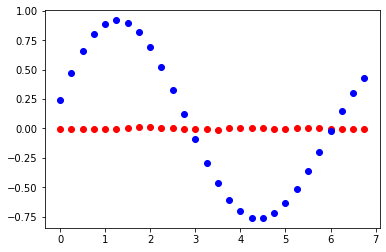

Epoch:  1


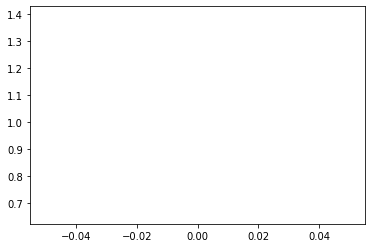

Epoch:  2


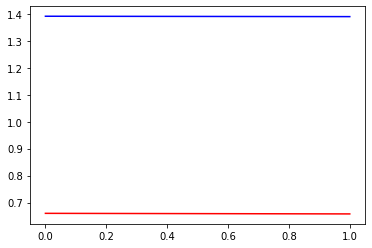

Epoch:  3


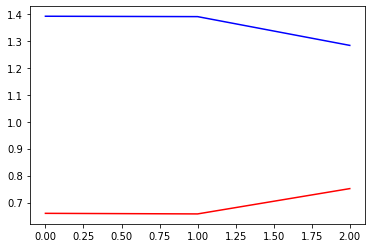

Epoch:  4


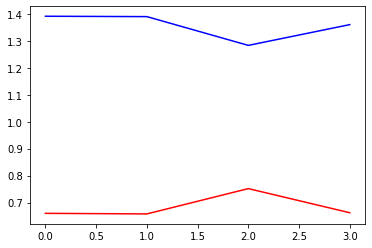

Epoch:  5


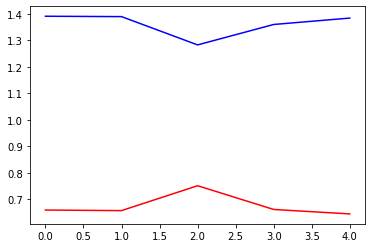

Epoch:  6


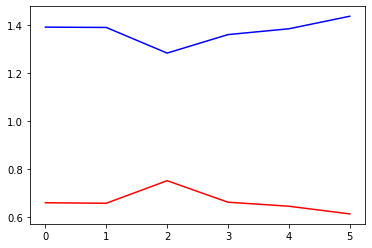

Epoch:  7


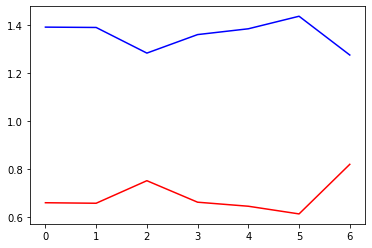

Epoch:  8


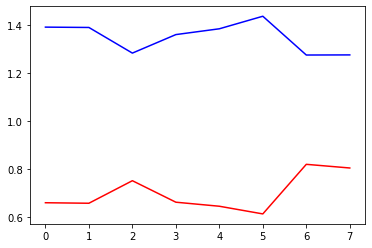

Epoch:  9


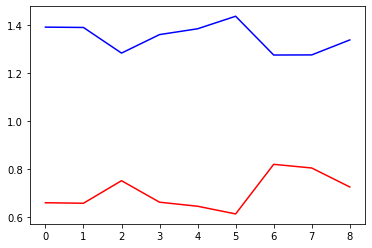

Epoch:  10


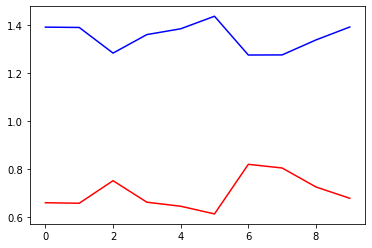

Epoch:  11


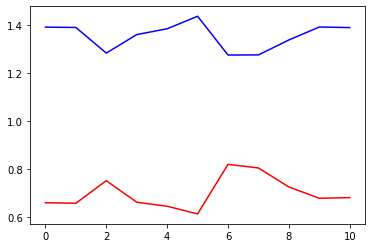

Epoch:  12


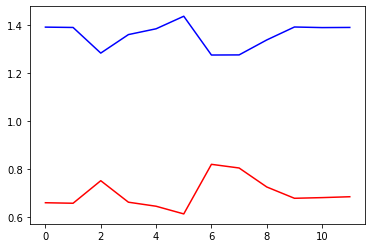

Epoch:  13


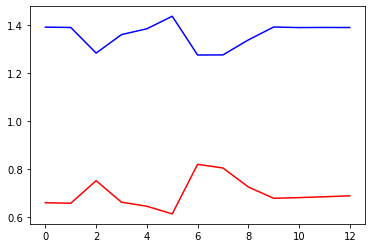

Epoch:  14


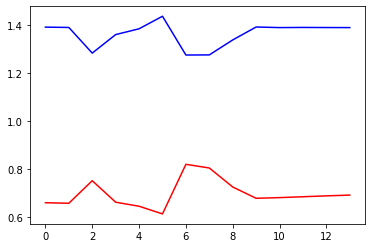

Epoch:  15


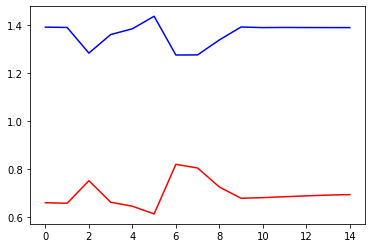

Epoch:  16


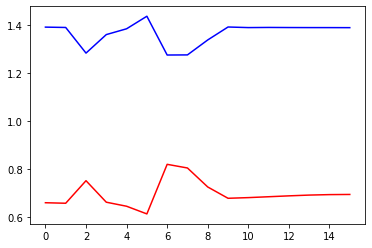

Epoch:  17


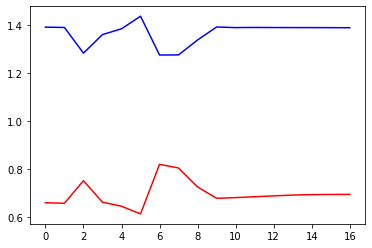

Epoch:  18


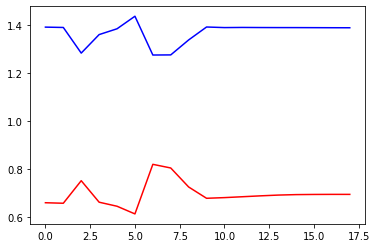

Epoch:  19


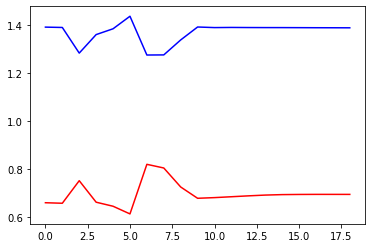

Epoch:  20


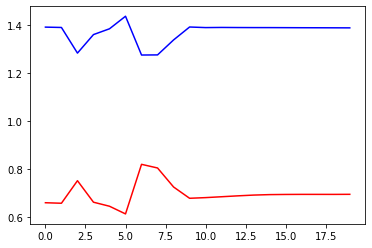

Epoch:  21


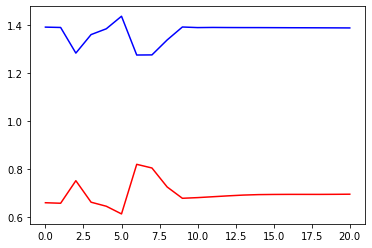

Epoch:  22


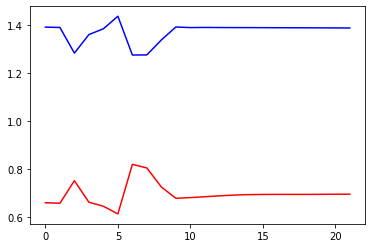

Epoch:  23


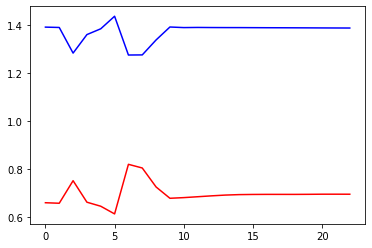

Epoch:  24


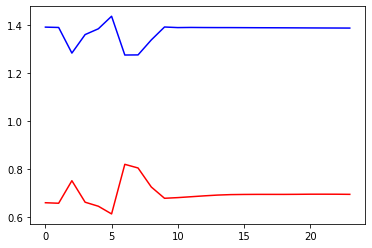

Epoch:  25


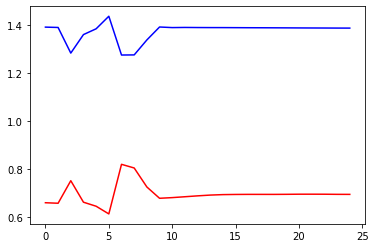

Epoch:  26


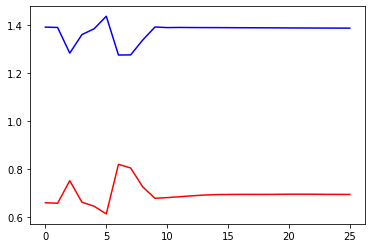

Epoch:  27


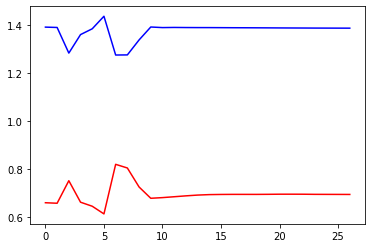

Epoch:  28


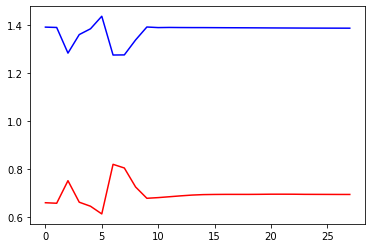

Epoch:  29


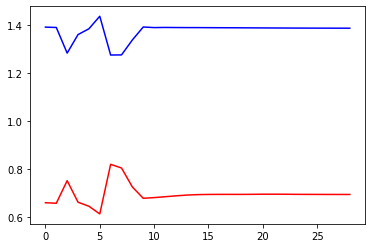

Epoch:  30


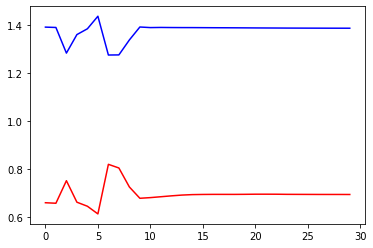

Epoch:  31


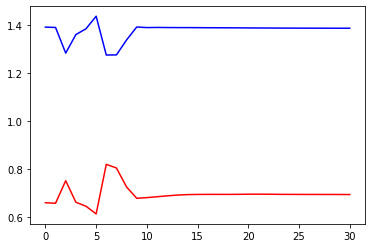

Epoch:  32


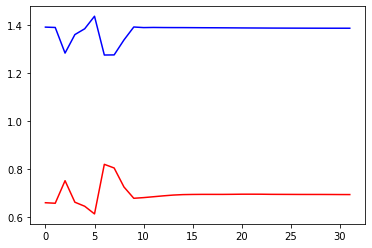

Epoch:  33


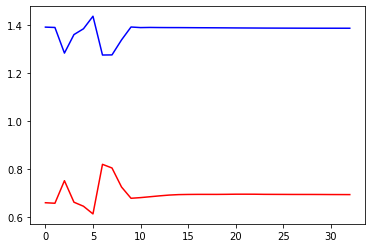

Epoch:  34


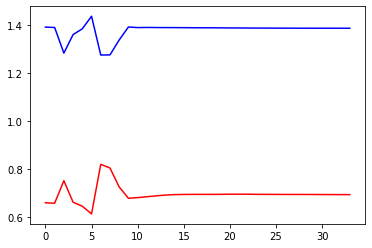

Epoch:  35


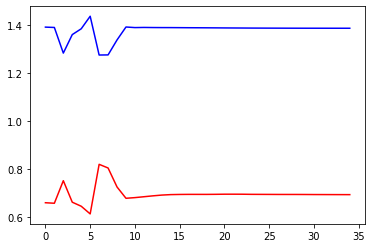

Epoch:  36


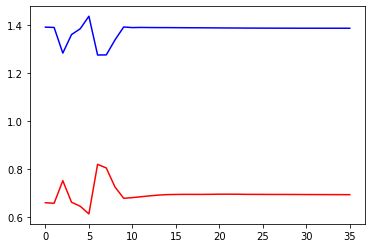

Epoch:  37


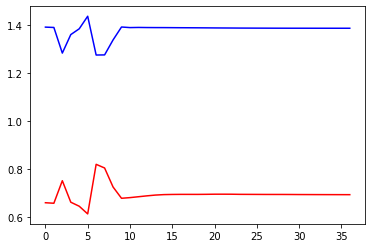

Epoch:  38


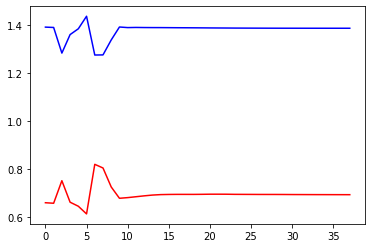

Epoch:  39


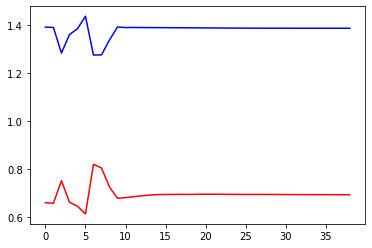

Epoch:  40


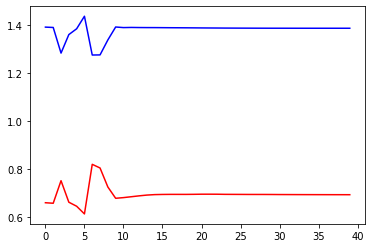

Epoch:  41


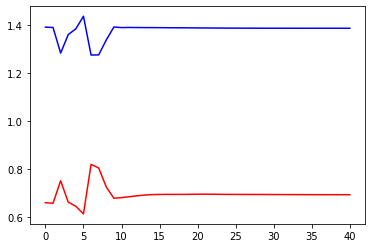

Epoch:  42


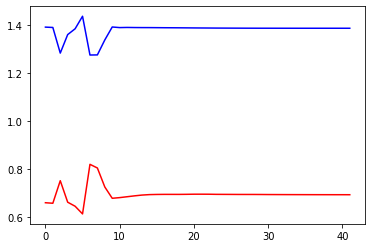

Epoch:  43


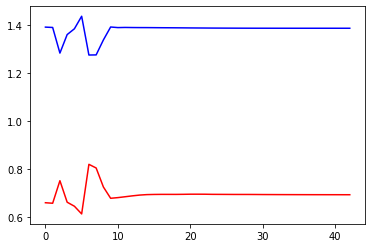

Epoch:  44


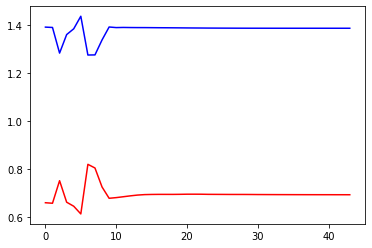

Epoch:  45


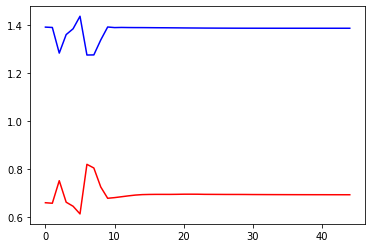

Epoch:  46


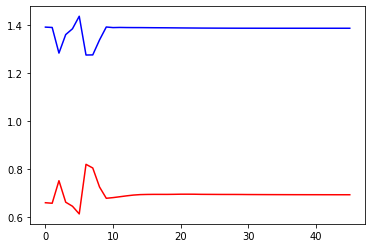

Epoch:  47


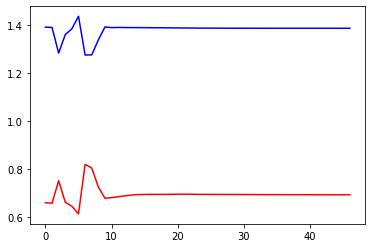

Epoch:  48


KeyboardInterrupt: ignored

In [ ]:
ShowSinPlot()
Training(100)
ShowSinPlot()

### Visualise

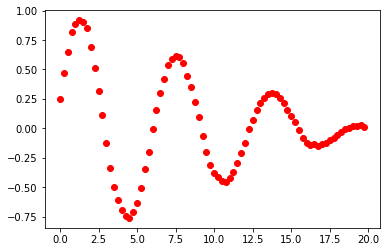

In [ ]:
  nums = np.arange(0, 20, 0.25)
  xD = []
  yD = []
  for i in range(nums.shape[0]):
    xD.append(S(nums[i]))
    yD.append(C(nums[i]))
  
  dat = np.stack((xD, yD), axis=1)
  
  plt.scatter(nums, sinGenerator.predict([dat]), c="red")
  plt.show()

#Sequences

In [ ]:
def GetSet(_size):
  ySet = np.random.randint(0, 3, _size)
  data = np.empty([0])
  yData = np.empty([0])

  for i in range(_size):
    a = ySet[i]
    start = rint(0, 30)
    if a == 0:
      data = np.append(data, np.arange(start, start + 16))
      yData = np.append(yData, np.array([1, 0, 0]))
    if a == 1:
      data = np.append(data, np.arange(start, start - 16, -1))
      yData = np.append(yData, np.array([0, 1, 0]))
    if a == 2:
      data = np.append(data, np.ones(16) * start)
      yData = np.append(yData, np.array([0, 0, 1]))

  data = data.reshape((_size, 16, 1))
  yData = yData.reshape((_size, 3))

  print(data.shape)
  print(yData.shape)

  return data, yData


In [ ]:
rnnModel = Sequential([
    Input(shape = (None, 1)),
    LSTM(10, return_sequences = True, activation = 'relu'),
    LSTM(5, activation = 'relu'),
    Dense(3, activation = 'sigmoid')
])

rnnModel.compile(loss='binary_crossentropy', optimizer='Adam', metrics=["accuracy"])

x, y = GetSet(64*128)

In [ ]:
rnnModel.fit(x, y, batch_size = 256, epochs = 32, validation_split=0.2, shuffle = True, verbose = 1)

In [ ]:
print(rnnModel.predict(np.array([1, 2, 3, 4, 5, 6]).reshape(6, 1)))
print()
print(rnnModel.predict(np.array([5, 5, 5, 5, 5, 5]).reshape(6, 1)))
print()
print(rnnModel.predict(np.array([6, 5, 4, 3, 2, 1]).reshape(6, 1)))

#File Read

In [129]:
filenames = []
for filename in os.walk(animFilePath):
  filenames = filename[2]  

In [130]:
animFileData = []
for i in range(0, len(filenames)):
  animFileData.append(AnimFileReader(f'{animFilePath}/{filenames[i]}'))
  animFileData[i].realData = animFileData[i].realData.reshape(animFileData[i].frameCount, 1, animFileData[i].realSize)
  animFileData[i].animData = animFileData[i].animData.reshape(animFileData[i].frameCount, 10, animFileData[i].frameSize)
  #print(animFileData[i].realData.shape)
  #print(animFileData[i].animData.shape)


In [131]:
animData = animFileData[0].animData
realData = animFileData[0].realData

for i in range(1, len(animFileData)):
  animData = np.append(animData, animFileData[i].animData, 0)
  realData = np.append(realData, animFileData[i].realData, 0)

animData = animData.astype(float)
realData = realData.astype(float)

print(animData.shape)
print(realData.shape)

(6055, 10, 6)
(6055, 1, 6)


#Animation GAN Training

##Training Vars

In [149]:
batchSize = 128
iterations = 750

genIn = animData.shape[-1]
genOut = realData.shape[-1]
discIn = animData.shape[-1]# + realData.shape[-1]

In [150]:
def GeneratorAnimBatch(_size, animData):
  batch = []
  rands = np.random.randint(0, animData.shape[0], size = _size)

  for i in range(_size):
    batch.append(animData[rands[i]])
  
  return np.array(batch)

def DiscrimAnimBatch(_size, animData, realData):
  batch = []
  rands = np.random.randint(0, animData.shape[0], size = _size)

  for i in range(_size):
    a = animData[rands[i]]
    a = np.append(a, realData[rands[i]])
    batch.append(a)

  batch = np.array(batch)

  return batch

def GetAnimBatches(_size, animData, realData, _width):
  genBatch = np.empty((0, 10, _width))
  realBatch = np.empty((0, 11, _width))
  justRealBatch = np.empty((0, 1, _width))
  rands = np.random.randint(0, animData.shape[0], size = _size)

  for i in range(_size):
    a = animData[rands[i]]
    b = realData[rands[i]]
    genBatch = np.append(genBatch, a)
    realBatch = np.append(realBatch, a)
    realBatch = np.append(realBatch, b)
    justRealBatch = np.append(justRealBatch, b)

  genBatch = genBatch.reshape((_size, 10, _width))
  realBatch = realBatch.reshape((_size, 11, _width))
  justRealBatch = justRealBatch.reshape(_size, 1, _width)
  return genBatch, realBatch, justRealBatch

##Networks

In [151]:
loadFromFile = False

Generator

In [152]:
if loadFromFile:
  animGenerator = tf.keras.models.load_model(f'{aiOutPath}/GenModel')
  animGenerator.summary()
else:
  outsidePow = 6
  insidePow = 7
  animGenerator = Sequential([
      Input(shape=(None, genIn)),
      LSTM(2**outsidePow, return_sequences=True, activation='relu'),
      Dense(2**insidePow, activation='relu'),
      Dense(2**insidePow, activation='relu'),
      LSTM(2**outsidePow, return_sequences=False, activation='relu'),
      Dropout(0.2),
      Dense(genOut)
  ])

clear_output()
animGenerator.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, None, 64)          18176     
                                                                 
 dense_72 (Dense)            (None, None, 128)         8320      
                                                                 
 dense_73 (Dense)            (None, None, 128)         16512     
                                                                 
 lstm_49 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_74 (Dense)            (None, 6)                 390       
                                                                 
Total params: 92,806
Trainable params: 92,806
Non-tra

Discriminator

In [153]:
if loadFromFile:
  animDiscriminator = tf.keras.models.load_model(f'{aiOutPath}/DiscModel')
  animDiscriminator.summary()
else:
  outsidePow = 7
  insidePow = 8
  animDiscriminator = Sequential([
      Input(shape=(None, discIn)),
      LSTM(2**outsidePow, return_sequences=True, activation='relu'),
      Dense(2**insidePow, activation='relu'),
      Dense(2**insidePow, activation='relu'),
      Dropout(0.2),
      LSTM(2**outsidePow, return_sequences=False, activation='relu'),
      Dense(1, activation='sigmoid')
  ])
clear_output()
animDiscriminator.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, None, 128)         69120     
                                                                 
 dense_75 (Dense)            (None, None, 256)         33024     
                                                                 
 dense_76 (Dense)            (None, None, 256)         65792     
                                                                 
 dropout_5 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_51 (LSTM)              (None, 128)               197120    
                                                                 
 dense_77 (Dense)            (None, 1)                 129       
                                                                 
Total params: 365,185
Trainable params: 365,185
Non-t

##Training Setup

In [154]:
animCrossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

animGenOp = tf.keras.optimizers.Adam(1e-4)
animDiscOp = tf.keras.optimizers.Adam(1e-4)

def AnimDiscLossCalculation(_realResults, _fakeResults):
  fLoss = animCrossEntropy(tf.zeros_like(_fakeResults), _fakeResults)
  rLoss = animCrossEntropy(tf.ones_like(_realResults), _realResults)
  return fLoss + rLoss

def AnimGenLossCalculation(_fakeResults):
  return animCrossEntropy(tf.ones_like(_fakeResults), _fakeResults)

In [155]:
@tf.function
def AnimTrainingStep():
  #genBatch = GeneratorAnimBatch(batchSize, animData)
  #realBatch = DiscrimAnimBatch(batchSize, animData, realData)

  genBatch, realBatch, onlyReal = GetAnimBatches(batchSize, animData, realData, genOut)

  with tf.GradientTape() as genGradTapeA, tf.GradientTape() as discGradTapeA:
    generatedBatch = animGenerator(genBatch)

    realResult = animDiscriminator(realBatch, training = True)
    generatedBatch = tf.experimental.numpy.reshape(generatedBatch, (batchSize, 1, genOut))
    
    fakeResult = animDiscriminator(tf.experimental.numpy.append(genBatch, generatedBatch, 1), training = True)

    genLoss = AnimGenLossCalculation(fakeResult)
    discLoss = AnimDiscLossCalculation(realResult, fakeResult)

    genGrads = genGradTapeA.gradient(genLoss, animGenerator.trainable_variables)
    discGrads = discGradTapeA.gradient(discLoss, animDiscriminator.trainable_variables)

    animGenOp.apply_gradients(zip(genGrads, animGenerator.trainable_variables))
    animDiscOp.apply_gradients(zip(discGrads, animDiscriminator.trainable_variables))

    return discLoss, genLoss

In [156]:
def AnimTraining(epochs):

  dLMean = [0]
  dLMin = [0]
  dLMax = [0]

  gLMean = [0]
  gLMin = [0]
  gLMax = [0]

  for epoch in range(epochs):
    print("Epoch: ", epoch + 1)
    T = time.time()
    dLoss = np.zeros(iterations)
    gLoss = np.zeros(iterations)

    for i in range(iterations):
      d, g = AnimTrainingStep()
      dLoss.put([i], [d])
      gLoss.put([i], [g])

    if(epoch > 0 and epoch % 25 == 0):
      animGenerator.save(f'{aiOutPath}/GenModel{epoch}')
      animGenerator.save_weights(f'{aiOutPath}/GenWeights{epoch}')
      animDiscriminator.save(f'{aiOutPath}/DiscModel{epoch}')
      animDiscriminator.save_weights(f'{aiOutPath}/DiscWeights{epoch}')
    
    dLMean.append(np.mean(dLoss))
    dLMin.append(np.min(dLoss))
    dLMax.append(np.max(dLoss))

    gLMean.append(np.mean(gLoss)/genOut)
    gLMin.append(np.min(gLoss)/genOut)
    gLMax.append(np.max(gLoss)/genOut)
    
    plt.clf()
    plt.plot(dLMin, c = (0, 0, 1, 0.2))
    plt.plot(dLMax, c = (0, 0, 1, 0.2))
    plt.plot(gLMin, c = (1, 0, 0, 0.2))
    plt.plot(gLMax, c = (1, 0, 0, 0.2))
    plt.plot(dLMean, c = (0, 0, 1, 1))
    plt.plot(gLMean, c = (1, 0, 0, 1))
    plt.ylim((0, 3))
    plt.show()
    print(f'Epoch took: {time.time() - T} seconds')
    T = time.time()

##Train

Epoch:  1


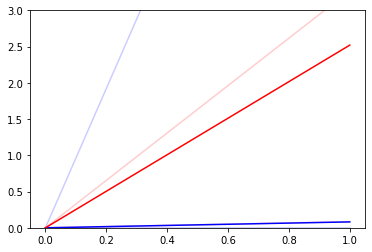

Epoch took: 45.361525774002075 seconds
Epoch:  2


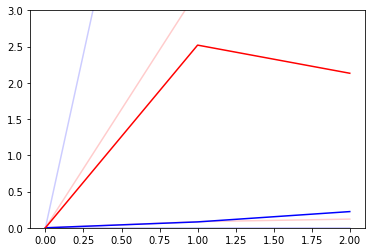

Epoch took: 36.173076152801514 seconds
Epoch:  3


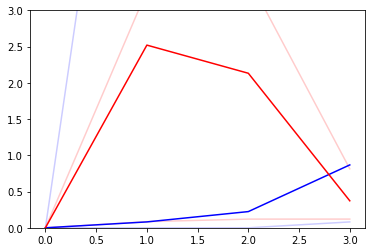

Epoch took: 37.27478814125061 seconds
Epoch:  4


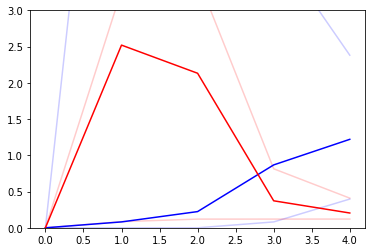

Epoch took: 35.969207525253296 seconds
Epoch:  5


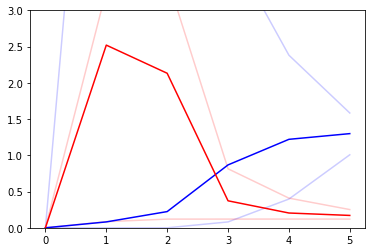

Epoch took: 35.76831316947937 seconds
Epoch:  6


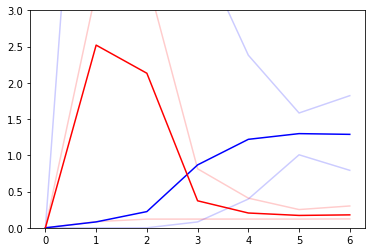

Epoch took: 35.99131679534912 seconds
Epoch:  7


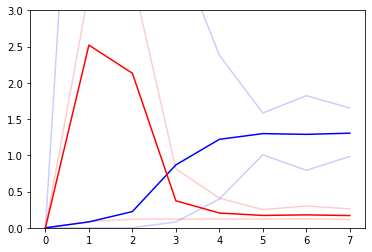

Epoch took: 35.782917737960815 seconds
Epoch:  8


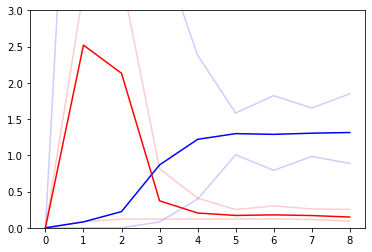

Epoch took: 35.88686919212341 seconds
Epoch:  9


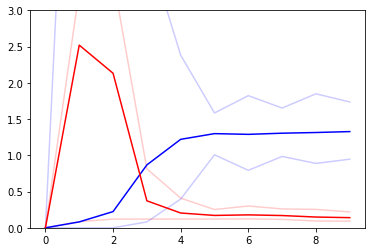

Epoch took: 35.760364055633545 seconds
Epoch:  10


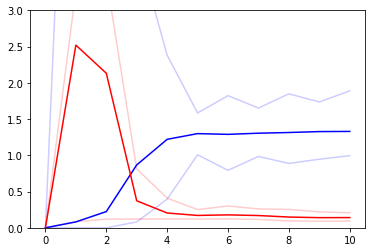

Epoch took: 35.87506985664368 seconds
Epoch:  11


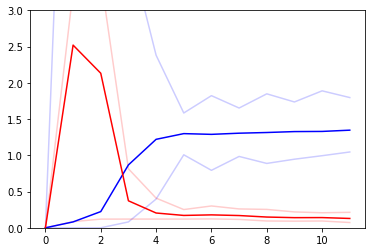

Epoch took: 36.135531187057495 seconds
Epoch:  12


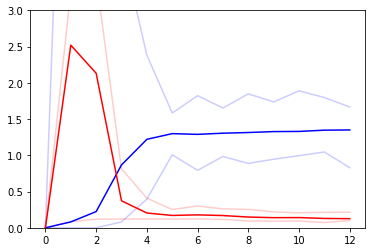

Epoch took: 35.92514491081238 seconds
Epoch:  13


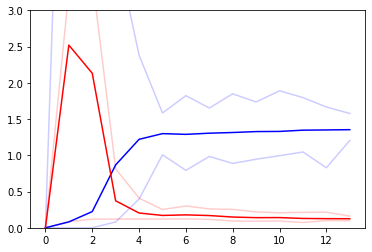

Epoch took: 35.9006233215332 seconds
Epoch:  14


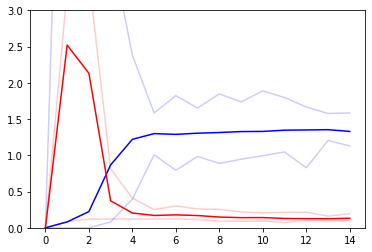

Epoch took: 35.88160729408264 seconds
Epoch:  15


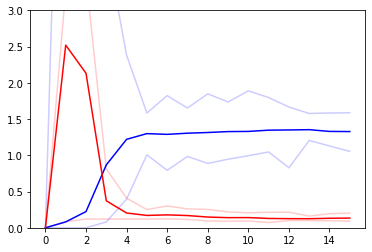

Epoch took: 35.8645339012146 seconds
Epoch:  16


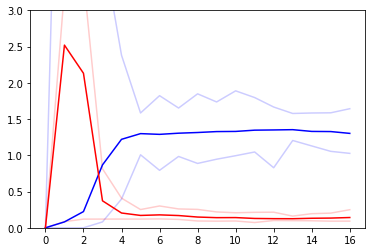

Epoch took: 35.75954461097717 seconds
Epoch:  17


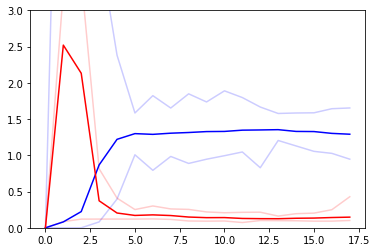

Epoch took: 36.268603801727295 seconds
Epoch:  18


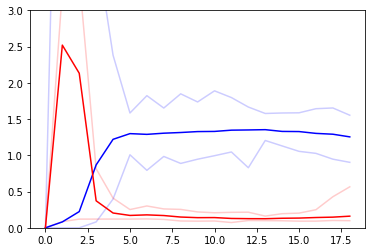

Epoch took: 37.02019262313843 seconds
Epoch:  19


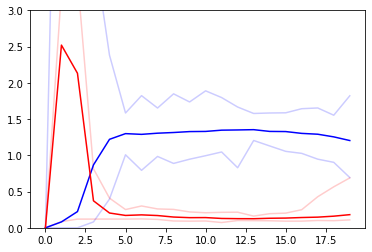

Epoch took: 37.23295474052429 seconds
Epoch:  20


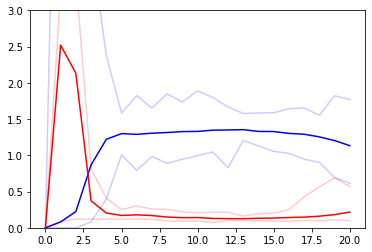

Epoch took: 36.816298961639404 seconds
Epoch:  21


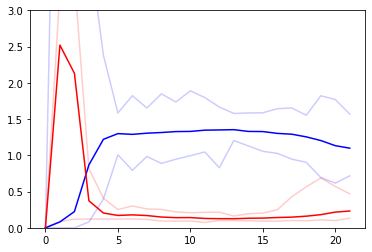

Epoch took: 37.236883878707886 seconds
Epoch:  22


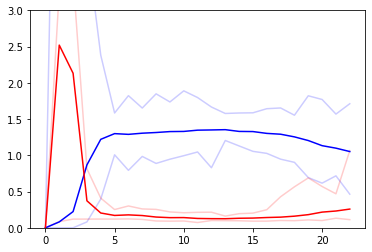

Epoch took: 36.70501399040222 seconds
Epoch:  23


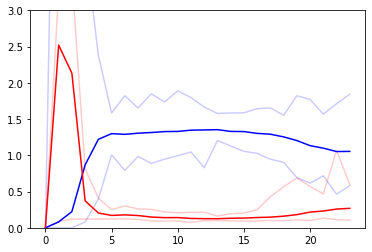

Epoch took: 36.98042321205139 seconds
Epoch:  24


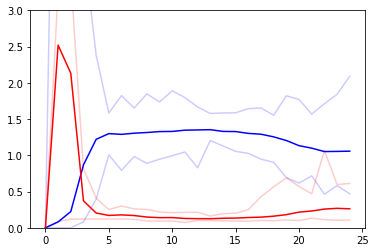

Epoch took: 37.18421745300293 seconds
Epoch:  25


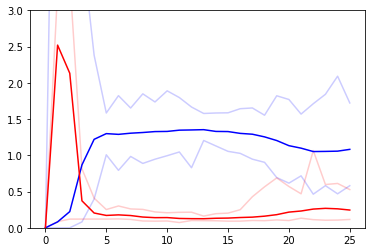

Epoch took: 37.560688734054565 seconds
Epoch:  26


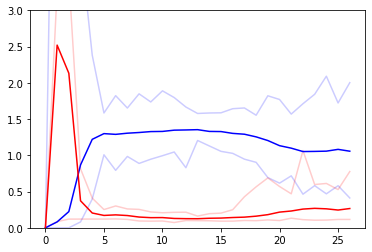

Epoch took: 43.23268723487854 seconds
Epoch:  27


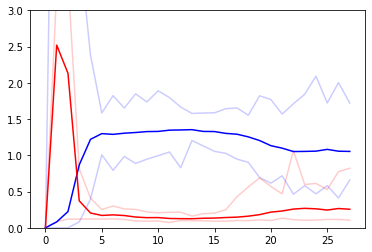

Epoch took: 36.10845375061035 seconds
Epoch:  28


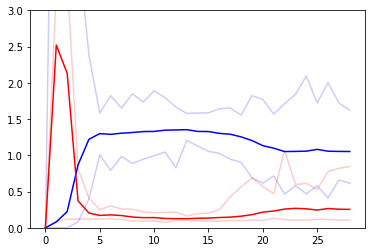

Epoch took: 36.28475880622864 seconds
Epoch:  29


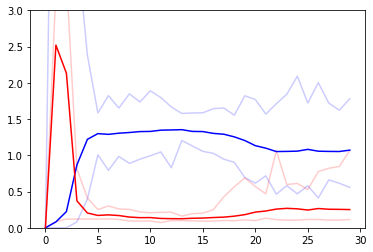

Epoch took: 36.13899278640747 seconds
Epoch:  30


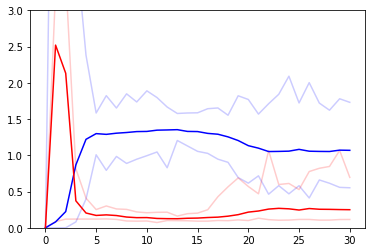

Epoch took: 36.57333707809448 seconds
Epoch:  31


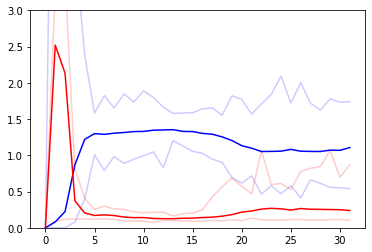

Epoch took: 35.98756241798401 seconds
Epoch:  32


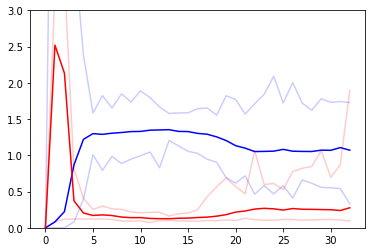

Epoch took: 35.81340503692627 seconds
Epoch:  33


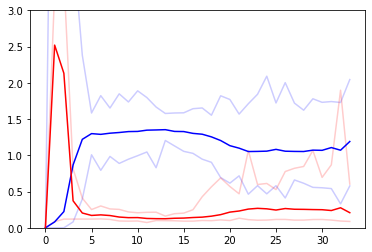

Epoch took: 35.693710803985596 seconds
Epoch:  34


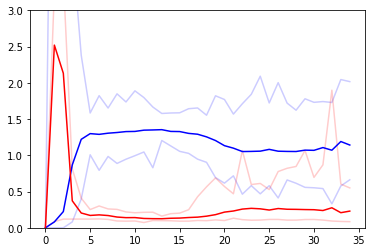

Epoch took: 35.41845107078552 seconds
Epoch:  35


KeyboardInterrupt: ignored

In [157]:
AnimTraining(60)

## Are you actually doing it right?

###Shhh

In [158]:
num = 5000

g, b, r = GetAnimBatches(num, animData, realData, genOut)

genBatch = animGenerator.predict(g).reshape(num, 1, genOut)

newBatch = np.append(g, genBatch, 1)




###Print

In [159]:
print("Results for real data:")
print(np.around(np.mean(animDiscriminator.predict(b)), 2))
print()
print("Results for generated data:")
print(np.around(np.mean(animDiscriminator.predict(newBatch)), 2))

Results for real data:
0.16

Results for generated data:
0.05
